# Convert Sigmet files into Zarr

## Imports

In [31]:
import fsspec
import xarray as xr
import numpy as np

from raw2zarr.builder.runner import append_files
from raw2zarr.utils import make_dir

Now let's convert some sigmet files hosted in the [IDEAM](https://registry.opendata.aws/ideam-radares/) AWS bucket.

In [41]:
radar = "Guaviare"
append_dim = "vcp_time"
engine = "iris"
zarr_format = 3
consolidated = True if zarr_format == 2 else False
zarr_store = f"../zarr/{radar}2.zarr"
query = f"2022/06/05/{radar}/{radar[:3].upper()}"
str_bucket = "s3://s3-radaresideam/l2_data"

In [42]:
f"../zarr/{radar}2.zarr"

'../zarr/Guaviare2.zarr'

In [43]:
f"{str_bucket}{query}*"

's3://s3-radaresideam/l2_data2022/06/05/Guaviare/GUA*'

In [44]:
fs = fsspec.filesystem("s3", anon=True)
radar_files = [f"s3://{i}" for i in sorted(fs.glob(f"{str_bucket}/{query}*"))]

In [45]:
len(radar_files)

1141

In [6]:
# ?append_files

In [7]:
%%time
append_files(
    radar_files[550:600],
    zarr_store=zarr_store,
    append_dim=append_dim,
    zarr_format=zarr_format,
    batch_size=10,
    engine=engine,
    consolidated=consolidated,
    process_mode="parallel",
)

/home/alfonso/mambaforge/envs/raw2zarr-dev/lib/python3.12/site-packages/xradar/io/backends/iris.py:249: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/home/alfonso/mambaforge/envs/raw2zarr-dev/lib/python3.12/site-packages/xradar/io/backends/iris.py:249: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/home/alfonso/mambaforge/envs/raw2zarr-dev/lib/python3.12/site-packages/xradar/io/backends/iris.py:249: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/home/alfonso/mambaforge/envs/raw2zarr-dev/lib/python3.12/site-packages/xradar/io/backends/iris.py:249: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/home/alfonso/mambaforge/envs/raw2zarr-dev/lib/python3.12/site-packages/xradar/io/backends/iris.py:249: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwar

CPU times: user 40.4 s, sys: 10.6 s, total: 51 s
Wall time: 1min 24s


## Read the radar datatree store in Zarr format

In [19]:
!ls ../zarr/Guaviare2.zarr

PRECA  PRECB  PRECC  SURVP  zarr.json


In [20]:
%%time
dt_radar = xr.open_datatree(
    zarr_store, 
    engine="zarr", 
    consolidated=False, 
    zarr_format=3, 
    chunks={}
)

CPU times: user 986 ms, sys: 268 ms, total: 1.25 s
Wall time: 1.14 s


In [21]:
dt_radar["/SURVP/sweep_0/DBZH"]

<xarray.DataArray 'DBZH' (vcp_time: 12, azimuth: 720, range: 994)> Size: 69MB
dask.array<open_dataset-DBZH, shape=(12, 720, 994), dtype=float64, chunksize=(1, 180, 249), chunktype=numpy.ndarray>
Coordinates:
  * vcp_time   (vcp_time) datetime64[ns] 96B 2022-06-05T11:30:04 ... 2022-06-...
    crs_wkt    int64 8B ...
  * azimuth    (azimuth) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
    altitude   float64 8B ...
    elevation  (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
  * range      (range) float32 4kB 1e+03 1.3e+03 1.6e+03 ... 2.986e+05 2.989e+05
    latitude   float64 8B ...
    longitude  float64 8B ...
    time       (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    y          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    x          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    z          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
Attributes:
    long_name:      Equivalent reflectivity factor H
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h

In [22]:
list(dt_radar.children)

['PRECA', 'PRECB', 'SURVP', 'PRECC']

We can now access each sweep by using a key-value method. Let's check the lowest elevation angle

In [23]:
ds_05 = dt_radar["SURVP/sweep_0"].ds
display(ds_05)

<xarray.DatasetView> Size: 807MB
Dimensions:            (vcp_time: 12, azimuth: 720, range: 994)
Coordinates:
  * vcp_time           (vcp_time) datetime64[ns] 96B 2022-06-05T11:30:04 ... ...
    crs_wkt            int64 8B ...
  * azimuth            (azimuth) float32 3kB 0.25 0.75 1.25 ... 359.2 359.8
    altitude           float64 8B ...
    elevation          (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
  * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    latitude           float64 8B ...
    longitude          float64 8B ...
    time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    y                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    x                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    z                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
Data variables: (12/17)
    DB_HCLASS          (vcp_time, azimuth, range) float32 34MB dask.array<chunksize=(1, 360, 497), meta=np.ndarray>
    DBZH               (vcp_time, azimuth, range) float64 69MB dask.array<chunksize=(1, 180, 249), meta=np.ndarray>
    DBTH               (vcp_time, azimuth, range) float64 69MB dask.array<chunksize=(1, 180, 249), meta=np.ndarray>
    DB_DBTE8           (vcp_time, azimuth, range) float64 69MB dask.array<chunksize=(1, 180, 249), meta=np.ndarray>
    DB_DBZE8           (vcp_time, azimuth, range) float64 69MB dask.array<chunksize=(1, 180, 249), meta=np.ndarray>
    follow_mode        (vcp_time) object 96B dask.array<chunksize=(12,), meta=np.ndarray>
    ...                 ...
    sweep_mode         (vcp_time) object 96B dask.array<chunksize=(12,), meta=np.ndarray>
    sweep_number       (vcp_time) float64 96B dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_fixed_angle  (vcp_time) float64 96B dask.array<chunksize=(1,), meta=np.ndarray>
    VRADH              (vcp_time, azimuth, range) float64 69MB dask.array<chunksize=(1, 180, 249), meta=np.ndarray>
    WRADH              (vcp_time, azimuth, range) float64 69MB dask.array<chunksize=(1, 180, 249), meta=np.ndarray>
    ZDR                (vcp_time, azimuth, range) float64 69MB dask.array<chunksize=(1, 180, 249), meta=np.ndarray>

Before creating a radar plot we need to georeference the dataset. This can be done using `xradar.georeference` module

Now we can create a radial plot

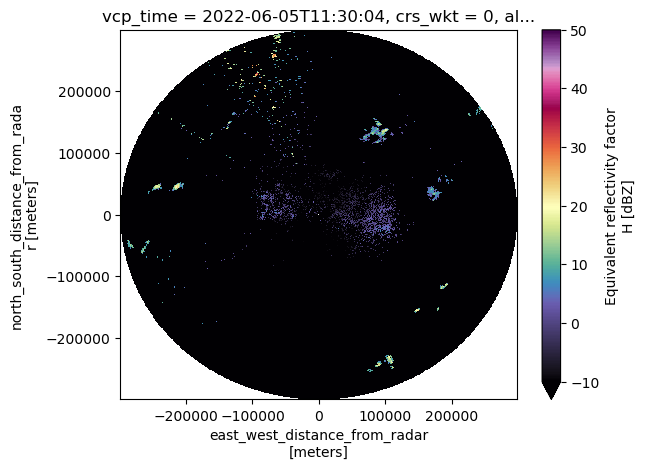

In [46]:
ds_05.isel(vcp_time=0).DBZH.plot(
    x="x", 
    y="y", 
    cmap="ChaseSpectral", 
    vmin=-10, 
    vmax=50
)